## Import Python Modules

In [ ]:
# GROUP 5
# Neel Gandhi, Sunishka Jain, Daniel Shen, Julian Wu

## MACHINE LEARNING MODELS
### This notebook takes in the data from 'processedData.csv'
### and creates 11 different models with it. 

### The list of models are:
### 1. XGBoost
### 2. Random Forest
### 3. SVM
### 4. Logistic Regression
### 5. Decision Tree
### 6. K-Nearest Neighbors
### 7. AdaBoost
### 8. GradientBoost
### 9. Gaussian Naive Bayes
### 10. Voting Classifier
### 11. Stacked Ensemble (our best model!)

In [ ]:
# Imports

import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.manifold._t_sne import TSNE
from sklearn.model_selection import GridSearchCV

# from imblearn.under_sampling import RandomUnderSampler 
# from imblearn.over_sampling import RandomOverSampler 

In [ ]:

# Import data
file = './processedData.csv'
data = pd.read_csv(file)

In [ ]:
data = data.drop(['Unnamed: 0'], axis=1)

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNVC',
       'CLASS', 'IMPACT', 'SYMBOL', 'cDNA_position', 'CDS_position',
       'Protein_position', 'STRAND', 'SIFT', 'PolyPhen', 'LoFtool',
       'CADD_PHRED', 'CADD_RAW', 'Amino_acid_ref', 'Amino_acid_alt', 'unknown',
       'germline', 'somatic', 'inherited', 'paternal', 'maternal', 'de-novo',
       'biparental', 'uniparental', 'not-tested', 'tested-inconclusive',
       'other_origin', 'missense_variant', 'synonymous_variant', 'other', 'IE',
       'IELOCATION', 'has_Hereditary_cancer-predisposing_syndrome',
       'has_Hereditary_breast_and_ovarian_cancer_syndrome',
       'has_Familial_cancer_of_breast', 'has_Dilated_cardiomyopathy_1G',
       'has_Limb-girdle_muscular_dystrophy,_type_2J',
       'has_Cardiovascular_phenotype', 'has_Hypertrophic_cardiomyopathy',
       'has_Ataxia-telangiectasia_syndrome',
       'has_Hereditary_nonpolyposis_colon_cancer',
       'has_Dilated_Cardiomyopathy,_Dominant',
   

In [ ]:
import numpy as np

from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Function to display scores
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
# Function to report the best scores from the results
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def confusion_metrics (conf_matrix):
    # Save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

    # Prints
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
# Cleaning 3 columns and replacing unnecessary characters

convert_feature = ['cDNA_position','CDS_position','Protein_position']
data['cDNA_position'] = data['cDNA_position'].astype(str).str.replace(r'\D+', '')
data['CDS_position'] = data['CDS_position'].astype(str).str.replace(r'\D+', '')
data['Protein_position'] = data['Protein_position'].astype(str).str.replace(r'\D+', '')
for i in range(len(convert_feature)):
  data[convert_feature[i]] = data[convert_feature[i]].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


## Splitting Dataset

In [ ]:
# Creating our X and Y for training

X = data.drop(columns=['CLASS'])
y = data['CLASS']

## t-SNE Before SMOTE Visualization

In [ ]:
#t-SNE 
tsne_result = TSNE(n_components=2, perplexity=20.0, verbose=1).fit_transform(X) 
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = tsne_result[:,0]
df["comp-2"] = tsne_result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue="y",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Conflicting Classifications T-SNE Projection") 
sns.set(rc={'figure.figsize':(20,20)})

In [ ]:
# This is before any under/oversampling

print(data['CLASS'].value_counts()[0])
print(data['CLASS'].value_counts()[1])
data['CLASS'].value_counts(normalize = True)

38090
12657


0    0.750586
1    0.249414
Name: CLASS, dtype: float64

In [ ]:
# Let's use SMOTE to oversample the minority class 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print(y.value_counts()[0])
print(y.value_counts()[1])
y.value_counts(normalize = True)

## t-SNE after SMOTE Visualization

In [ ]:
#t-SNE 
tsne_result2 = TSNE(n_components=2, perplexity=20.0, verbose=1).fit_transform(X) 

df = pd.DataFrame()
df["y2"] = y
df["comp-3"] = tsne_result2[:,0]
df["comp-4"] = tsne_result2[:,1]


sns.scatterplot(x="comp-3", y="comp-4", hue="y2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Conflicting Classifications T-SNE Projection after SMOTE") 
sns.set(rc={'figure.figsize':(20,20)})

In [ ]:
from sklearn.model_selection import train_test_split

# Create training and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [ ]:
df_accur_roc_score = pd.DataFrame(columns=['Roc_Auc_Score'])

## XGBoost Classifer

[[9186 2241]
 [2414 9013]]


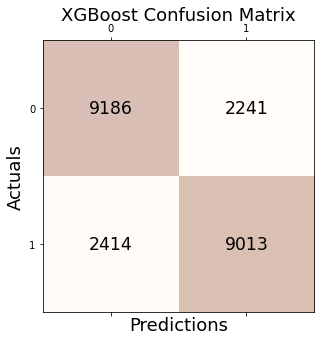

True Positives: 9013
True Negatives: 9186
False Positives: 2241
False Negatives: 2414
--------------------------------------------------
Accuracy: 0.8
Mis-Classification: 0.2
Sensitivity: 0.79
Specificity: 0.8
Precision: 0.8
f_1 Score: 0.8


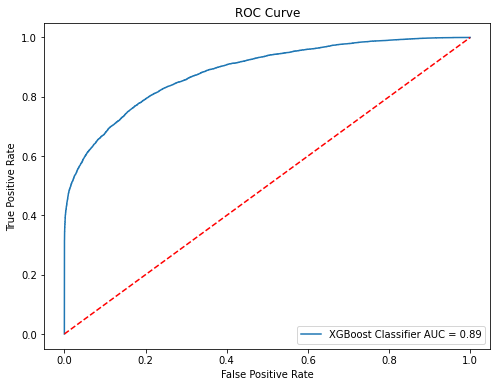

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('XGBoost Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = xgb_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['XGBoost_Classifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='XGBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Hyperparameter Tuning for XG Boost

In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
# Model and performance evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [ ]:
# Define the search space
param_grid_XGB = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['accuracy']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb_model, 
                           param_distributions=param_grid_XGB, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=4)
# Fit grid search
random_result = random_search.fit(X_train, y_train)
# Print grid search summary
random_result

Fitting 3 folds for each of 48 candidates, totalling 144 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_ty...
                                           predictor='auto', random_state=42, ...),
                   n_iter=48, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': range(3, 21, 3),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 1, 10,
                                                       100]},
                   refit='accuracy', scoring=['accuracy'], verbose=4)

In [ ]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
#print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 0.8459
The best hyperparameters are {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.4}


## Tuned XGBoost

[[10146  1281]
 [ 2059  9368]]


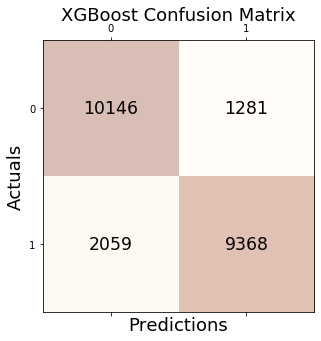

True Positives: 9368
True Negatives: 10146
False Positives: 1281
False Negatives: 2059
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.82
Specificity: 0.89
Precision: 0.89
f_1 Score: 0.85


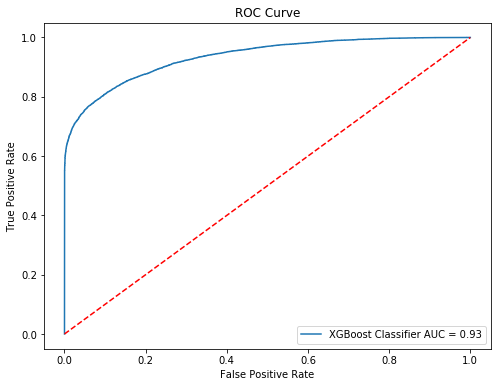

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, reg_lambda= 0.01, reg_alpha= 0.01, max_depth= 18, learning_rate= 0.1, gamma=0.0, colsample_bytree= 0.4)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('XGBoost Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = xgb_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['XGBoost_Classifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='XGBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Logistic Regression

[[  221 11206]
 [  135 11292]]


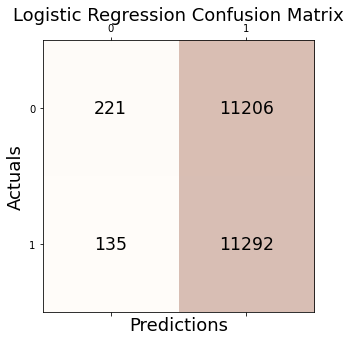

True Positives: 11292
True Negatives: 221
False Positives: 11206
False Negatives: 135
--------------------------------------------------
Accuracy: 0.5
Mis-Classification: 0.5
Sensitivity: 0.99
Specificity: 0.02
Precision: 0.02
f_1 Score: 0.04


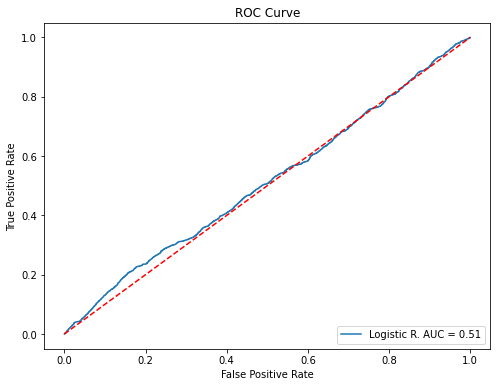

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=0).fit(X_train,y_train)
y_pred = lr_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Logistic Regression Confusion Matrix', fontsize=18)
plt.show()



confusion_metrics(conf_matrix)



y_preds = lr_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['Logistic_regression'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Logistic R. AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Decision Tree Classifer


[[8754 2673]
 [2416 9011]]


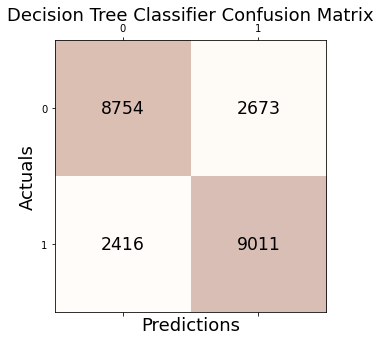

True Positives: 9011
True Negatives: 8754
False Positives: 2673
False Negatives: 2416
--------------------------------------------------
Accuracy: 0.78
Mis-Classification: 0.22
Sensitivity: 0.79
Specificity: 0.77
Precision: 0.77
f_1 Score: 0.78


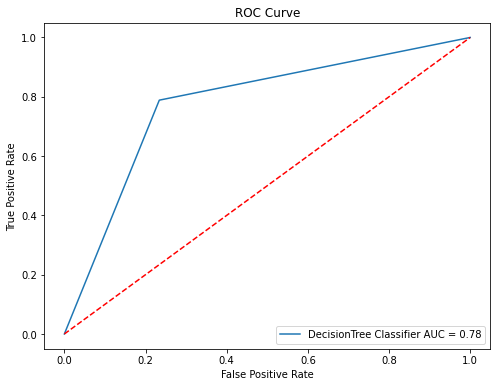

In [ ]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

dt_model = tree.DecisionTreeClassifier()
dt_model = dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Decision Tree Classifier Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = dt_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['DecisionTreeClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='DecisionTree Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


## Random Forest Classifier

[[9905 1522]
 [2470 8957]]


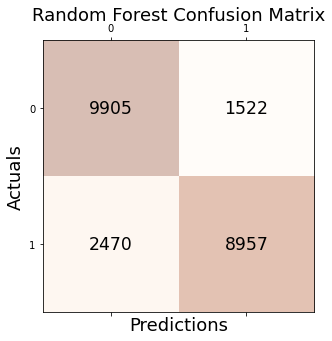

True Positives: 8957
True Negatives: 9905
False Positives: 1522
False Negatives: 2470
--------------------------------------------------
Accuracy: 0.83
Mis-Classification: 0.17
Sensitivity: 0.78
Specificity: 0.87
Precision: 0.87
f_1 Score: 0.82


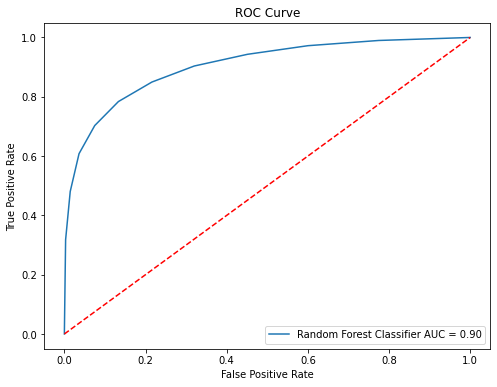

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rf_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Random Forest Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = rf_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['RandomForestClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Random Forest Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


## Hyperparameter Tuning for Random Forest

In [ ]:
#from sklearn.model_selection import RandomSearchCV
# Create the parameter grid based on the results of random search 
param_grid_RF = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
RS_RF = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid_RF, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
RS_RF.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=10,
                                                    random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 1000]},
                   verbose=2)

In [ ]:
#print(RS_RF.best_estimator)
# Print the best score and the corresponding hyperparameters
print(f'The best score is {RS_RF.best_score_:.4f}')
#print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {RS_RF.best_params_}')

The best score is 0.8137
The best hyperparameters are {'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 90, 'bootstrap': True}


## Tuned Random Forest Model

[[9497 1930]
 [2132 9295]]


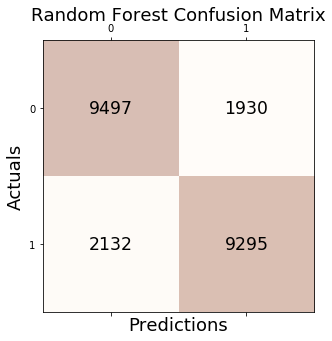

True Positives: 9295
True Negatives: 9497
False Positives: 1930
False Negatives: 2132
--------------------------------------------------
Accuracy: 0.82
Mis-Classification: 0.18
Sensitivity: 0.81
Specificity: 0.83
Precision: 0.83
f_1 Score: 0.82


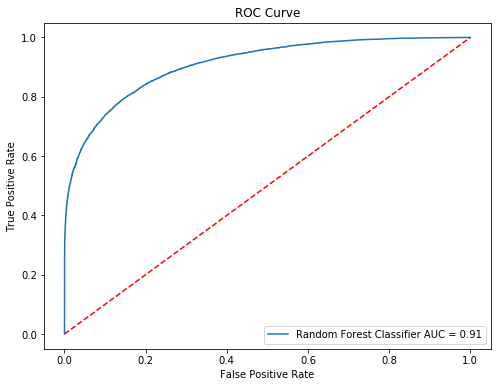

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=12, min_samples_leaf=3, max_features= 3, max_depth=90, bootstrap= True, random_state = 0)
rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Random Forest Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = rf_model.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['RandomForestClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Random Forest Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()


## K Nearest Neighbours

[[7335 4092]
 [3625 7802]]


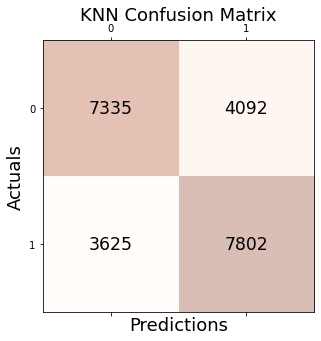

True Positives: 7802
True Negatives: 7335
False Positives: 4092
False Negatives: 3625
--------------------------------------------------
Accuracy: 0.66
Mis-Classification: 0.34
Sensitivity: 0.68
Specificity: 0.64
Precision: 0.64
f_1 Score: 0.66


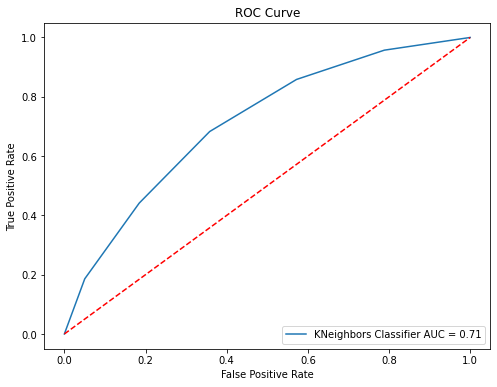

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')
neigh =  neigh.fit(X_train,y_train)
y_pred = neigh.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('KNN Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = neigh.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['KNeighborsClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='KNeighbors Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## AdaBoost Classifer

[[8883 2544]
 [2601 8826]]


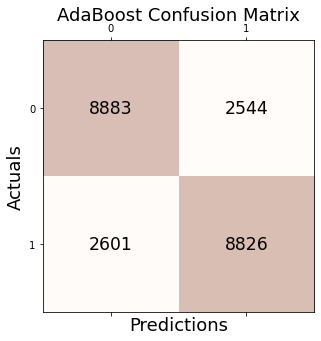

True Positives: 8826
True Negatives: 8883
False Positives: 2544
False Negatives: 2601
--------------------------------------------------
Accuracy: 0.77
Mis-Classification: 0.23
Sensitivity: 0.77
Specificity: 0.78
Precision: 0.78
f_1 Score: 0.77


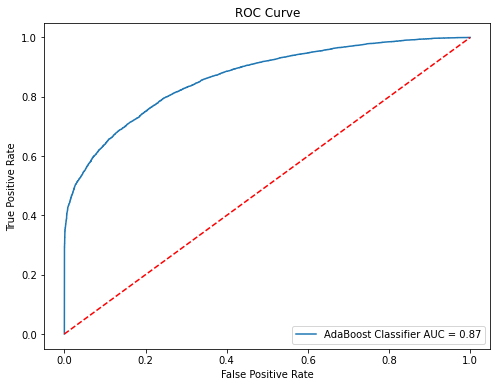

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf =  clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('AdaBoost Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['AdaBoostClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AdaBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Gradient Boost

[[9046 2381]
 [2658 8769]]


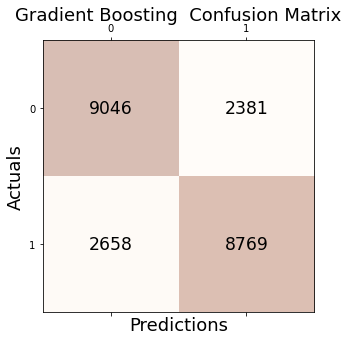

True Positives: 8769
True Negatives: 9046
False Positives: 2381
False Negatives: 2658
--------------------------------------------------
Accuracy: 0.78
Mis-Classification: 0.22
Sensitivity: 0.77
Specificity: 0.79
Precision: 0.79
f_1 Score: 0.78


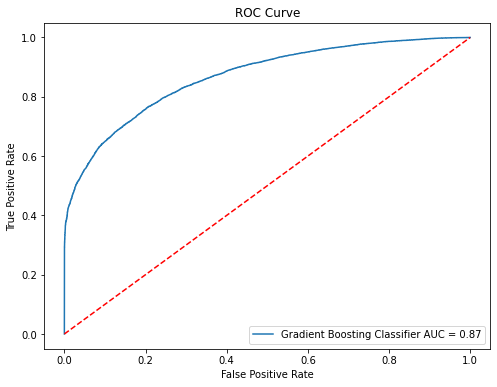

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Gradient Boosting  Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GradientBoostingClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Gradient Boosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Support Vector Machine

[[8861 2566]
 [3227 8200]]


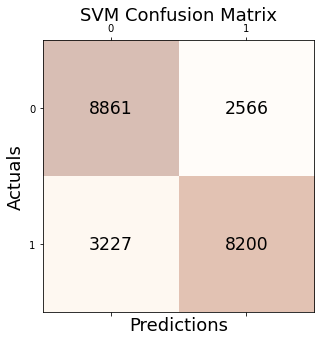

True Positives: 8200
True Negatives: 8861
False Positives: 2566
False Negatives: 3227
--------------------------------------------------
Accuracy: 0.75
Mis-Classification: 0.25
Sensitivity: 0.72
Specificity: 0.78
Precision: 0.78
f_1 Score: 0.75


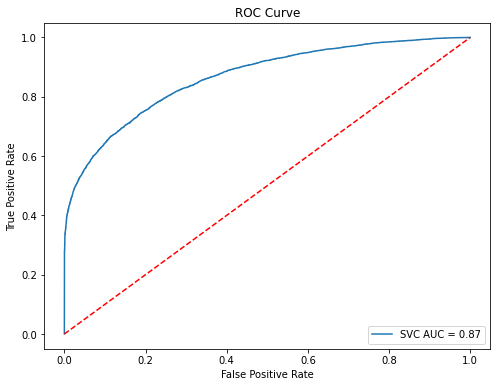

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('SVM Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['SVC'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='SVC AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Hyperparameter Tuning for SVM - took too long and pipeline error with randomized search

In [ ]:
# #from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid_SVM = {
#               'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']
# } 
  
# RS_SVM = GridSearchCV(SVC(), param_grid_SVM, refit = True, verbose = 3)
  
# # fitting the model for grid search
# RS_SVM.fit(X_train, y_train)

In [ ]:
# # Instantiate the grid search model
# RS_SVM = RandomizedSearchCV(estimator = svm_model, param_distributions = param_grid_SVM, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# RS_SVM.fit(X_train, y_train)

In [ ]:
# # Print the best accuracy score for the training dataset
# print(f'The best accuracy score for the training dataset is {RS_SVM.best_score_:.4f}')
# # Print the hyperparameters for the best score
# print(f'The best hyperparameters are {RS_SVM.best_params_}')
# # Print the best accuracy score for the testing dataset
# print(f'The accuracy score for the testing dataset is {RS_SVM.score(X_test_transformed, y_test):.4f}')

## Gaussian Naive Bayes

[[    4 11423]
 [   15 11412]]


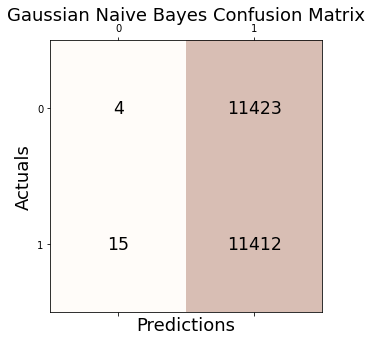

True Positives: 11412
True Negatives: 4
False Positives: 11423
False Negatives: 15
--------------------------------------------------
Accuracy: 0.5
Mis-Classification: 0.5
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
f_1 Score: 0.0


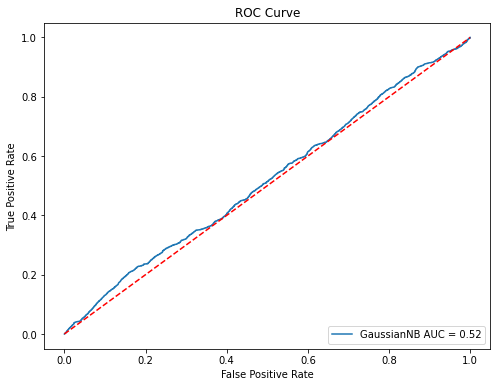

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Gaussian Naive Bayes Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['GaussianNB'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='GaussianNB AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

## Proposed Stacked Ensemble Machine Learning Model


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

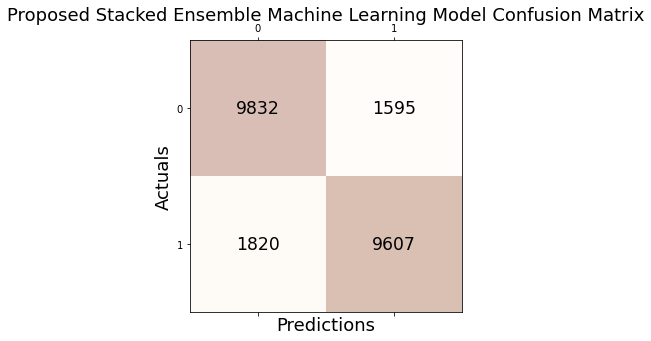

True Positives: 9607
True Negatives: 9832
False Positives: 1595
False Negatives: 1820
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.84
Specificity: 0.86
Precision: 0.86
f_1 Score: 0.85


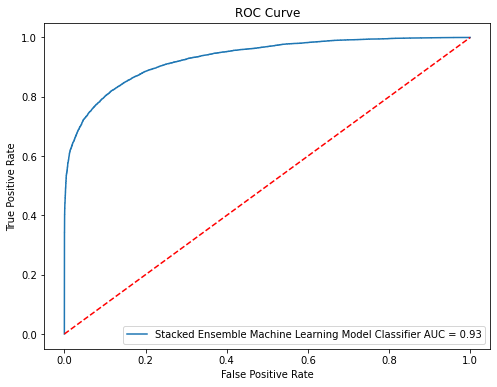

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42))),('xgb',xgb.XGBClassifier(objective="binary:logistic", random_state=42))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train).score(X_test, y_test)
y_pred = clf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Proposed Stacked Ensemble Machine Learning Model Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['StackedEnsembleClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Stacked Ensemble Machine Learning Model Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

# Stacked Ensemble Model with Tuned Basic Models

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

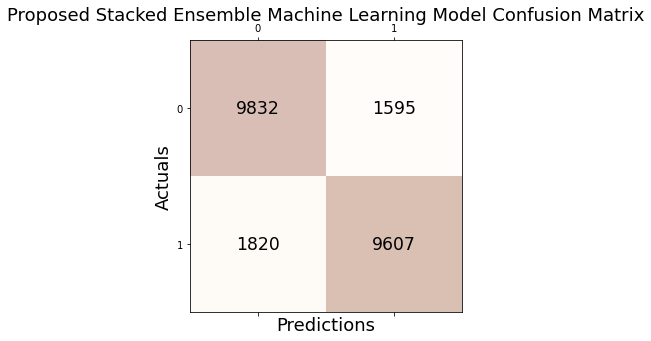

True Positives: 9607
True Negatives: 9832
False Positives: 1595
False Negatives: 1820
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.84
Specificity: 0.86
Precision: 0.86
f_1 Score: 0.85


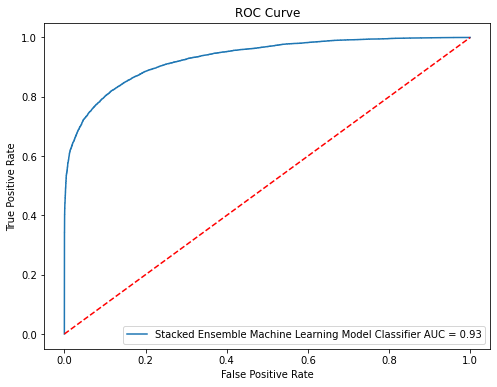

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(n_estimators=300, min_samples_split=12, min_samples_leaf=3, max_features=3, max_depth=90, bootstrap=True)),('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42))),('xgb',xgb.XGBClassifier(reg_lambda=0.01, reg_alpha=0.01, max_depth=18, learning_rate=0.1, gamma=0.0, colsample_bytree=0.4))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000))
clf.fit(X_train, y_train).score(X_test, y_test)
y_pred = clf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Proposed Stacked Ensemble Machine Learning Model Confusion Matrix', fontsize=18)
plt.show()


confusion_metrics(conf_matrix)

y_preds = clf.predict_proba(X_test)
preds = y_preds[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)
df_accur_roc_score.loc['StackedEnsembleClassifier'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Stacked Ensemble Machine Learning Model Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

# Explainable AI

## Lime

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=34ea7ea6b714e4ef047dbc8ad6b852508dd3f0cd27eda793808ab9a23dbc4a1c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
my_model = RandomForestClassifier(n_estimators=1000,
                                  random_state=42).fit(X_train, y_train)

In [ ]:
import lime
import lime.lime_tabular
 
data.dropna()
classes = ['consistent','conflicting']
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.astype(int).values,  
mode='classification',training_labels=y_train,feature_names = X_test.columns.tolist(),class_names=classes)

#Let's take a look for the patient in 100th row
i = 100
exp = explainer.explain_instance(X_train.loc[i,X_test.columns.tolist()].astype(int).values, my_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


## Permutation Feature Importance

In [ ]:
!pip install eli5

     |████████████████████████████████| 216 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 3.7 MB/s eta 0:00:011
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107728 sha256=21da94996c1b4af487b82a6caa75223f0ea702a7be1556bee887e6c45c99b752
  Stored in directory: /Users/danielshen/Library/Caches/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.2
    Uninstalling Jinja2-2.11.2:
      Successfully uninstalled Jinja2-2.11.2


In [ ]:
# Calculating and Displaying importance using the eli5 library
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

# Training and fitting a Random Forest Model
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0835 ± 0.0030,missense_variant
0.0555 ± 0.0031,AF_EXAC
0.0343 ± 0.0036,AF_TGP
0.0272 ± 0.0012,Amino_acid_alt
0.0232 ± 0.0023,AF_ESP
0.0222 ± 0.0008,has_Hereditary_cancer-predisposing_syndrome
0.0159 ± 0.0035,LoFtool
0.0134 ± 0.0020,IMPACT
0.0108 ± 0.0023,REF
0.0078 ± 0.0010,synonymous_variant


## SHAP

In [ ]:
!pip install shap

     |████████████████████████████████| 436 kB 6.7 MB/s eta 0:00:01
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [ ]:
# Training and fitting a Decision Tree
from sklearn.tree import DecisionTreeClassifier

feature_names = [i for i in data.columns]
tree_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
row_to_show = 10
data_for_prediction = X_test.iloc[row_to_show] 

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

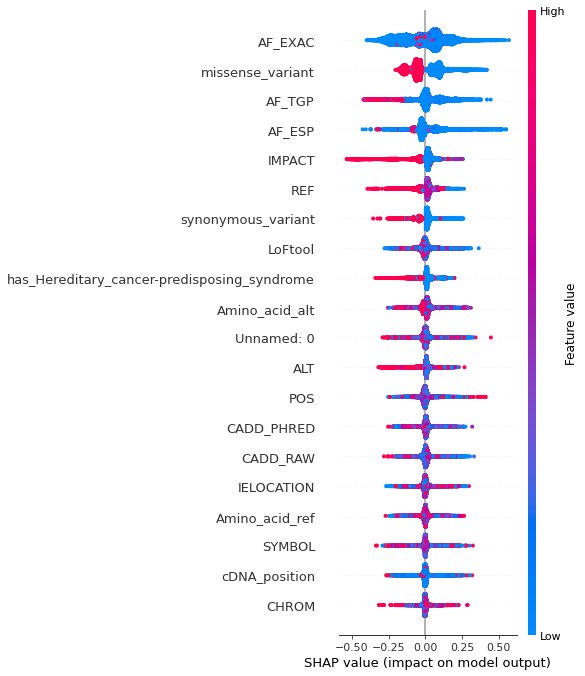

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1],X_test)

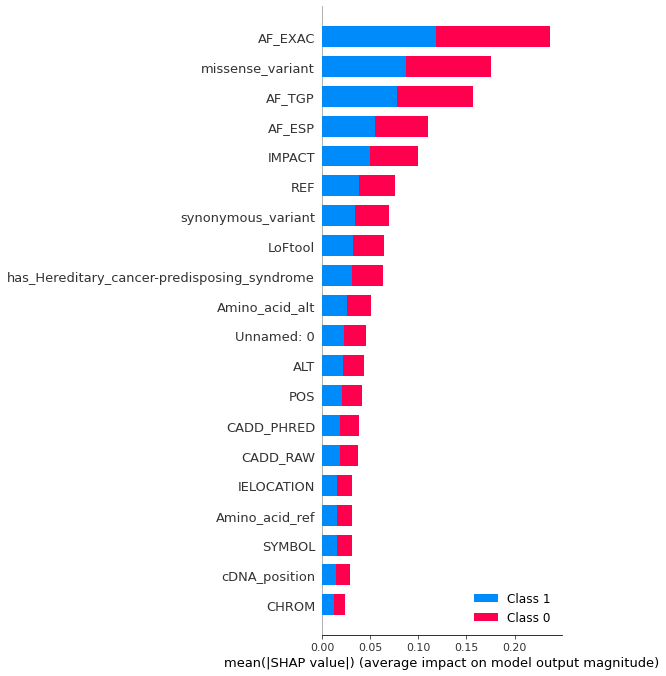

In [ ]:
shap.summary_plot(shap_values, X_test)

## Partial Dependence Plot

In [ ]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 20.3 MB/s eta 0:00:01         | 8.1 MB 5.7 MB/s eta 0:00:05
     |████████████████████████████████| 37.8 MB 14.8 MB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758226 sha256=72100392ffe498dcaae138bd2cedbb3b56f9a45ea87597e3b821019e52c857c7
  Stored in directory: /Users/danielshen/Library/Caches/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=8462542 sha256=4589238c367dda8e337be28ba428982a85b404fd07e4024418b8915c06d63d88
  Stored in directory: /Users/danielshen/Library/Caches/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
Successfully built pdpbox matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.2
    Uninstalling matplotlib-3.3.2:
      Successfully uninstalled matplotlib-3.3.2


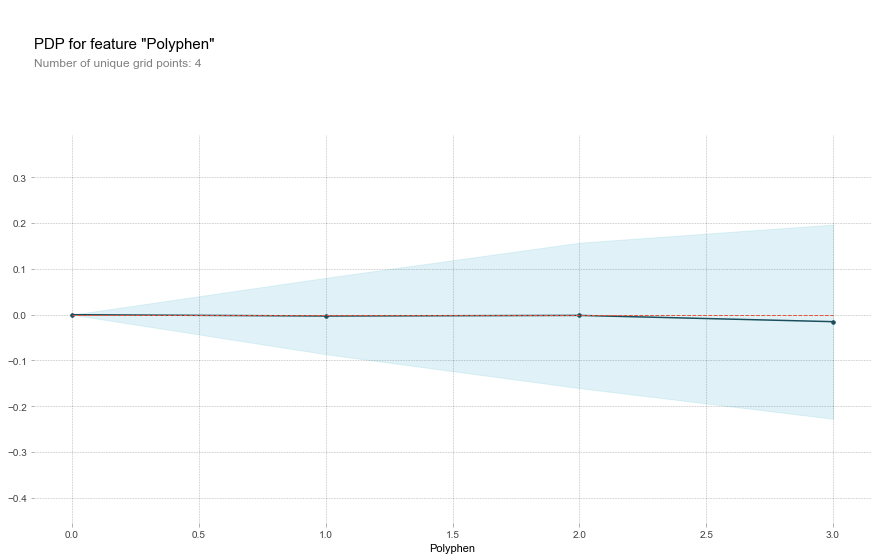

In [ ]:
from pdpbox import pdp, get_dataset, info_plots
feature_names = [i for i in data.columns]

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=X_test.columns.tolist(), feature='PolyPhen')

# Plot it
pdp.pdp_plot(pdp_goals, 'Polyphen')
plt.show()

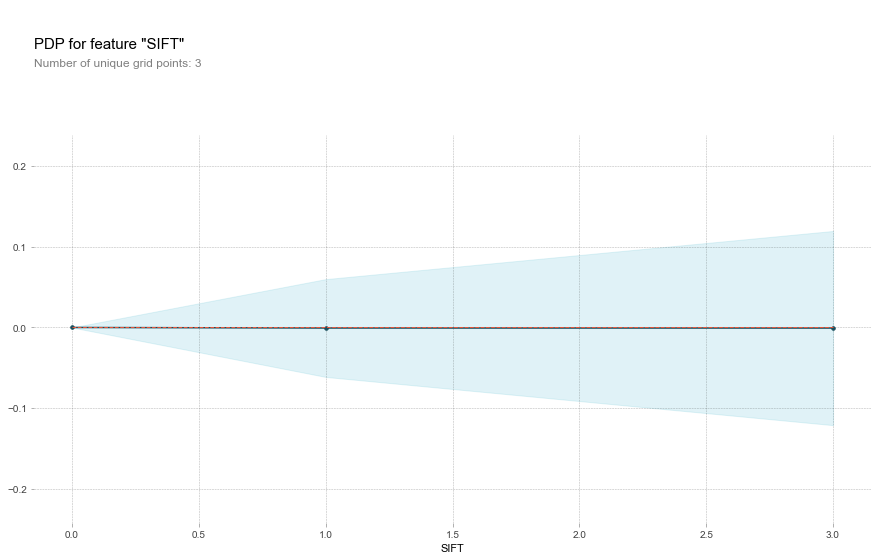

In [ ]:
from pdpbox import pdp, get_dataset, info_plots
feature_names = [i for i in data.columns]

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=X_test.columns.tolist(), feature='SIFT')

# Plot it
pdp.pdp_plot(pdp_goals, 'SIFT')
plt.show()

## Feature Importance Distribution

## Feature Interaction

In [ ]:
classes=['0','1']
target=data['CLASS']

In [ ]:
rfc=RandomForestClassifier(random_state=1234)
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=1234)

In [ ]:
rfc.score(X_test,y_test)

0.8466351623348211

In [ ]:
parameters={"n_estimators":[10,20,50,100,200],
           "max_depth":[2,3],
           "min_samples_split":[2,3,4],
           "max_features":('auto','log2'),
           "criterion":('gini','entropy')}
clf=GridSearchCV(rfc, parameters, cv=5)
clf.fit(X_train,y_train)
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
estimator=clf.best_estimator_
estimator.score(X_test,y_test)

0.7311630349173012

In [ ]:
import eli5

# Create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=X_test.columns.tolist())
feat_imp_df = feat_imp_df[:10]

In [ ]:
# all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
#                                      estimator],
#                                columns=X_test.columns.tolist())

# (sns.boxplot(data=all_feat_imp_df)
#         .set(title='Feature Importance Distributions',
#              ylabel='Importance'));